# COMP 551 A3
Esther Chen, Grace Hu, Kristen Peng

In [6]:
import os
import copy
import h5py
import pickle
from glob import glob
from random import shuffle

import cv2
from PIL import Image
from IPython.display import SVG

import numpy as np
import pandas as pd

import sklearn.utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)
import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, BatchNormalization, Convolution2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, concatenate, UpSampling2D, Conv2DTranspose

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

Tensorflow version: 2.2.0
Using TensorFlow backend.


In [ ]:
def get_model(input_shape=(28, 28*5, 3), p=0.5, n_class=11):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    x = BatchNormalization()(inputs)
    x = Convolution2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/4)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/4)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    # I had to remove this part because the input size we have is too small for a network this deep.
    # Another alternative would have been change the maxpool strides.
    
    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    #x = Dropout(p)(x)
    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    #x = Dropout(p)(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x) # I also reduced the number of activations
    x = Dense(1024, activation='relu')(x)
    
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    
    output = [c1, c2, c3, c4, c5]
    
    model = Model(inputs=inputs, outputs=output)

    return model


In [ ]:
def convert_output(model_output):
    model_output = np.array(model_output).swapaxes(0, 1)
    labels = []
    for output in model_output:
        label = convert_label(output)
        labels.append(label)

    return labels

In [8]:
h5f = h5py.File('MNIST_synthetic.h5','r')

print(h5f.keys())
# Extract the datasets
X_train = h5f['train_dataset'][:]       # remove
y_train = h5f['train_labels'][:]
X_test=h5f['train_dataset'][:] 
y_test=h5f['train_labels'][:]
#X_val = h5f['valid_dataset'][:]
#y_val = h5f['valid_labels'][:]
X_kaggle = h5f['test_dataset'][:]
#y_test = h5f['test_labels'][:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_train = h5f['train_dataset'][:]       # remove
y_train = h5f['train_labels'][:]
# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape)

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
Training set (56000, 64, 64, 1) (56000, 5)
Validation set (11200, 64, 64, 1) (11200, 5)
Test set (56000, 64, 64, 1)


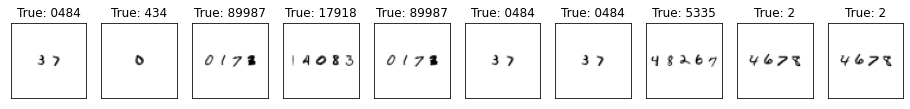

In [ ]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(X_kaggle[:10], 1, 10, y_train[:10])
        


In [ ]:
def convert_labels(labels):
    converted_labels=[]
    for i,label in enumerate(labels):
        n_label = np.zeros((5, 11), dtype='int')
        for j,digit in enumerate(label):
            if digit == "10":
                n_digit = "."
            else:
                n_digit = int(digit)

            n_label[j][n_digit] = 1
        converted_labels.append(n_label)
    y_temp = np.array(converted_labels)
    print(y_temp.shape)    
    y1 = y_temp[:, 0, :]
    y2 = y_temp[:, 1, :]
    y3 = y_temp[:, 2, :]
    y4 = y_temp[:, 3, :]
    y5 = y_temp[:, 4, :]

                

            
    #converted_labels.append(n_label)
    return [y1,y2,y3,y4,y5]

In [ ]:
labels=convert_labels(y_train)
#y_train=np.array(labels)
print((np.array(labels)).shape)

(56000, 5, 11)
(5, 56000, 11)


In [ ]:
def convert_label(label):
    n_label = ""
    for digit in label:
        if np.argmax(digit) == 10:
            n_digit = "."
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label

In [ ]:
model = get_model(input_shape=(64,64, 1))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 48)   1248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 48)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-3)
model.compile(optimizer, loss='categorical_crossentropy')
model.fit(X_train, labels, epochs=500, verbose=0,steps_per_epoch=1)
teste_out = model.predict(X_train)
#model.fit()

In [ ]:
output = convert_output(teste_out)

rows_to_plot = 4
cols_to_plot = 2
print(output)
print(y_train)
f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, test_imgs)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import random
def generator(size,train_data,train_labels, batch_size=32):
    """
    This generator receives mnist digits and labels and returns a batch for training

    Input:
    numbers - array with mnist images.
    number_labels - array with mnist labels.

    Arguments:
    batch_size - size of the mini batch

    Output:
    X_train and y_train
    """
    while True:  # Loop forever so the generator never terminates

        images = []
        labels = []

        #for batch_sample in range(batch_size):
        index=random.sample(range(0,size), batch_size)
        xs,ys = train_data[index],train_labels[index]
            
            # Here we will convert the label to a format that Keras API can process:
        for label in ys:
            n_label = np.zeros((5, 11), dtype='int')
            for i, digit in enumerate(label):
                if digit == ".":
                    n_digit = 10
                else:
                    n_digit = int(digit)

                n_label[i][n_digit] = 1
                
            #images.append(img)
            #labels.append(label)
            labels.append(n_label)

        X_train = np.array(xs)
        #print(X_train.shape)
        #if len(X_train.shape) == 3:
        #X_train = np.expand_dims(X_train, 0)
        #print(X_train.shape)

        y_temp = np.array(labels)
        
        y1 = y_temp[:, 0, :]
        y2 = y_temp[:, 1, :]
        y3 = y_temp[:, 2, :]
        y4 = y_temp[:, 3, :]
        y5 = y_temp[:, 4, :]

        yield X_train, [y1, y2, y3, y4, y5]

In [ ]:
model = get_model(input_shape=(64,64, 1))
optimizer = Adam(lr=1e-3)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

trn_generator = generator(56000,X_train, y_train, batch_size=128)
val_generator = generator(11190,X_val, y_val, batch_size=128)

In [ ]:
model.fit_generator(trn_generator,
                    epochs=5,
                    steps_per_epoch=780,
                    validation_data=val_generator,
                    validation_steps=780,
                    verbose=1,
                    shuffle=True)


Epoch 1/5
780/780 [==============================] - 8788s 11s/step - loss: 3.2734 - dense_17_loss: 0.9028 - dense_18_loss: 0.8674 - dense_19_loss: 0.6819 - dense_20_loss: 0.4817 - dense_21_loss: 0.3396 - dense_17_categorical_accuracy: 0.6825 - dense_18_categorical_accuracy: 0.6963 - dense_19_categorical_accuracy: 0.7634 - dense_20_categorical_accuracy: 0.8350 - dense_21_categorical_accuracy: 0.8879 - val_loss: 0.6118 - val_dense_17_loss: 0.1071 - val_dense_18_loss: 0.1077 - val_dense_19_loss: 0.0862 - val_dense_20_loss: 0.0668 - val_dense_21_loss: 0.0426 - val_dense_17_categorical_accuracy: 0.9694 - val_dense_18_categorical_accuracy: 0.9694 - val_dense_19_categorical_accuracy: 0.9778 - val_dense_20_categorical_accuracy: 0.9825 - val_dense_21_categorical_accuracy: 0.9875
Epoch 2/5
780/780 [==============================] - 8755s 11s/step - loss: 0.3774 - dense_17_loss: 0.1019 - dense_18_loss: 0.0934 - dense_19_loss: 0.0804 - dense_20_loss: 0.0572 - dense_21_loss: 0.0444 - dense_17_cate

780/780 [==============================] - 8756s 11s/step - loss: 0.1564 - dense_17_loss: 0.0418 - dense_18_loss: 0.0416 - dense_19_loss: 0.0327 - dense_20_loss: 0.0221 - dense_21_loss: 0.0181 - dense_17_categorical_accuracy: 0.9897 - dense_18_categorical_accuracy: 0.9894 - dense_19_categorical_accuracy: 0.9915 - dense_20_categorical_accuracy: 0.9939 - dense_21_categorical_accuracy: 0.9953 - val_loss: 0.0395 - val_dense_17_loss: 0.0222 - val_dense_18_loss: 0.0158 - val_dense_19_loss: 0.0173 - val_dense_20_loss: 0.0050 - val_dense_21_loss: 0.0034 - val_dense_17_categorical_accuracy: 0.9947 - val_dense_18_categorical_accuracy: 0.9966 - val_dense_19_categorical_accuracy: 0.9953 - val_dense_20_categorical_accuracy: 0.9984 - val_dense_21_categorical_accuracy: 0.9990


In [ ]:
y_labels=convert_labels(y_test)

#print(y_labels.shape)

In [ ]:
model.evaluate(X_test,y_labels)#predict on trianing data--overfit
test_pred = model.predict(X_test)
test_pred_labels = convert_output(test_pred)
test_true_labels = convert_output(y_labels)
print(test_pred_labels)
print(test_true_labels)

In [ ]:
accuracy = accuracy_score(test_true_labels, test_pred_labels)
print( "Accuracy: ", accuracy*100, "%")

In [ ]:
def convert_labels_back(labels):#concerted . to 10 for writing csv
    converted_labels=[]
    for i,label in enumerate(labels):
        n_label = ""
        for j,digit in enumerate(label):
            if digit == ".":
                n_digit = "10"
            else:
                n_digit = str(digit)

            n_label+=n_digit
        converted_labels.append(n_label)
    return converted_labels

In [ ]:
input_labels=convert_labels_back(test_pred_labels)
print(test_pred_labels)
print(input_labels)

In [ ]:
import csv
import os.path
def write_csv(output,filename):
    headers = ['Id', 'Label']

    for i,label in enumerate(output):
       
        print(i)
        row=[str(i),label]
        print(row)
            #if i>13999:

        with open(filename, 'a') as f:
            file_is_empty = os.stat(filename).st_size == 0
            writer = csv.writer(f, delimiter =",", lineterminator='\n')

            if file_is_empty:
                writer.writerow(headers)
            writer.writerow(row)
        

In [ ]:
write_csv(input_labels,"test.csv")

In [ ]:
kaggle_pred = model.predict(X_kaggle)
kaggle_pred_labels = convert_output(kaggle_pred)
Kaggle_input_labels=convert_labels_back(kaggle_pred_labels)
write_csv(Kaggle_input_labels,"kaggle3.csv")

In [ ]:
#model.evaluate(X_val, y_train)
model.fit(X_train, y_labels, epochs=500, verbose=0,steps_per_epoch=1)
teste_out = model.predict(X_val)
output = convert_output(teste_out)

rows_to_plot = 4
cols_to_plot = 2
print(output)
print(y_val)
f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, X_val)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# HYPERPARAMETER OPTIMIZATION

In [ ]:
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)
import keras
import keras.backend as K
import random

from keras.models import Model
from keras.layers import Input, BatchNormalization, Convolution2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, concatenate, UpSampling2D, Conv2DTranspose

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

from talos.utils import lr_normalizer


h5f = h5py.File('MNIST_synthetic.h5','r')

print(h5f.keys())
# Extract the datasets
X_train = h5f['train_dataset'][:-50]       # remove
y_train = h5f['train_labels'][:-50]
X_test=h5f['train_dataset'][-50:] 
y_test=h5f['train_labels'][-50:]
#X_val = h5f['valid_dataset'][:]
#y_val = h5f['valid_labels'][:]
X_kaggle = h5f['test_dataset'][:]
#y_test = h5f['test_labels'][:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape)

labels=convert_labels(y_train)


"""
    model.add(Dense(y_train.shape[1],
                    activation=params['last_activation']))

    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val])
"""

In [ ]:
def get_model(input_shape=(28, 28*5, 3), p=0.5, n_class=11):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    x = BatchNormalization()(inputs)
    x = Convolution2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/4)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/4)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    # I had to remove this part because the input size we have is too small for a network this deep.
    # Another alternative would have been change the maxpool strides.
    
    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    #x = Dropout(p)(x)
    #x = BatchNormalization()(x)
    #x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    #x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    #x = Dropout(p)(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x) # I also reduced the number of activations
    x = Dense(1024, activation='relu')(x)
    
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    
    output = [c1, c2, c3, c4, c5]
    
    model = Model(inputs=inputs, outputs=output)

    return model


def generator(size,train_data,train_labels, batch_size=32):
    """
    This generator receives mnist digits and labels and returns a batch for training

    Input:
    numbers - array with mnist images.
    number_labels - array with mnist labels.

    Arguments:
    batch_size - size of the mini batch

    Output:
    X_train and y_train
    """
    while True:  # Loop forever so the generator never terminates

        images = []
        labels = []

        #for batch_sample in range(batch_size):
        index=random.sample(range(0,size), batch_size)
        xs,ys = train_data[index],train_labels[index]
            
            # Here we will convert the label to a format that Keras API can process:
        for label in ys:
            n_label = np.zeros((5, 11), dtype='int')
            for i, digit in enumerate(label):
                if digit == ".":
                    n_digit = 10
                else:
                    n_digit = int(digit)

                n_label[i][n_digit] = 1
                
            #images.append(img)
            #labels.append(label)
            labels.append(n_label)

        X_train = np.array(xs)
        #print(X_train.shape)
        #if len(X_train.shape) == 3:
        #X_train = np.expand_dims(X_train, 0)
        #print(X_train.shape)

        y_temp = np.array(labels)
        
        y1 = y_temp[:, 0, :]
        y2 = y_temp[:, 1, :]
        y3 = y_temp[:, 2, :]
        y4 = y_temp[:, 3, :]
        y5 = y_temp[:, 4, :]

        yield X_train, [y1, y2, y3, y4, y5]



def train(X_train, y_train, X_val, y_val, params):
    model = get_model(input_shape=(64,64, 1))   #static
    
    model.compile(params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
    loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    trn_generator = generator(44760,X_train, y_train, batch_size=128)
    val_generator = generator(11190,X_val, y_val, batch_size=128)

    model.fit_generator(trn_generator,
                        epochs=params['epoch'],
                        validation_data=val_generator,
                        verbose=1,
                        shuffle=True)

In [18]:
def convert_output(model_output):
    model_output = np.array(model_output).swapaxes(0, 1)
    labels = []
    for output in model_output:
        label = convert_label(output)
        labels.append(label)

    return labels


def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
#plot_images(X_train[:2], 1, 2, y_train[:2])

def convert_labels(labels):
    converted_labels=[]
    for i,label in enumerate(labels):
        n_label = np.zeros((5, 11), dtype='int')
        for j,digit in enumerate(label):
            if digit == "10":
                n_digit = "."
            else:
                n_digit = int(digit)

            n_label[j][n_digit] = 1
        converted_labels.append(n_label)
    y_temp = np.array(converted_labels)
    print(y_temp.shape)    
    y1 = y_temp[:, 0, :]
    y2 = y_temp[:, 1, :]
    y3 = y_temp[:, 2, :]
    y4 = y_temp[:, 3, :]
    y5 = y_temp[:, 4, :]

                

            
    #converted_labels.append(n_label)
    return [y1,y2,y3,y4,y5]



def convert_label(label):
    n_label = ""
    for digit in label:
        if np.argmax(digit) == 10:
            n_digit = "."
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label

In [ ]:
model = get_model(input_shape=(64,64, 1))